In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors

import astropy.io.fits as pyfits
import astropy.wcs as wcs

import os
import time

from scipy.optimize import curve_fit
from scipy.stats import kstest

import sklearn
from sklearn.cluster import DBSCAN
#import sklearn.cluster.HDBSCAN

In [2]:
## import functions
import GMM_plot_library as pGMM
import GMM_functions as fGMM
import velocity_axis_datacube as vax

# Gaussian Mixture model example
- Works for a 3D spectral datacube, clusters data cube based on spectra morphology (see Kabanovic+2020 for a description)
- Here, the GMM clustering is applied to RCW 79

In [3]:
#### User input ####

## input for the data file
path_file = 'data/'
name_file = 'RCW79_CII_PCA_20_8_0p5_clean.fits'
unit_integrated_intensity = '$\int$T$_{mb}$dv (K km s$^{-1}$)'

## plotting options 
dpi_val = 300
path_plots = 'plots/'
save_name = 'GMM_RCW79.pdf'

## input for the Gaussian Mixture Models
n_comps_min = 1
n_comps_max = 11

n_comps_min1 = 1
n_comps_max1 = 5#21

## information for the observational information
noise_rms_obs = 0.6 ## K
min_velocity = -70. ## km/s
max_velocity = -25. ## km/s
unit_intensity = "T$_{mb}$ (K)"
unit_z_axis = "v (km s$^{-1}$)"

## spectral resolutions of the resampled data (need to be higher than the native velocity resolution)
dv_resamps = [1., 1.5, 2.] ## in km/s

## Boolean to determine whether to work with decimate or resample
resample_bool = False 

########################

## Execute the script

In [4]:
## get the data and header information
hdu = pyfits.open(path_file + name_file)
hdu.info()
data = hdu[0].data
header = hdu[0].header

## store the spectral information (in km/s)
dv = 0.001*header['CDELT3']
crval = 0.001*header['CRVAL3']
crpix = header['CRPIX3']
print(dv)

## store the WCS information
header_c = header.copy()
header_c['NAXIS'] = 2
del header_c['NAXIS3']
del header_c['CTYPE3']
del header_c['CRVAL3']
del header_c['CDELT3']
del header_c['CRPIX3']
del header_c['CROTA3']

w = wcs.WCS(header_c)
print(w)

Filename: data/RCW79_CII_PCA_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (188, 188, 160)   float32   
0.5
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SFL'  'DEC--SFL'  
CRVAL : 205.02442  -61.710261  
CRPIX : 97.82400030166  92.32306353733  
NAXIS : 188  188


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SFL'  'DEC--SFL'  
CRVAL : 205.02442  -61.710261  
CRPIX : 97.82400030166  92.32306353733  
NAXIS : 188  188


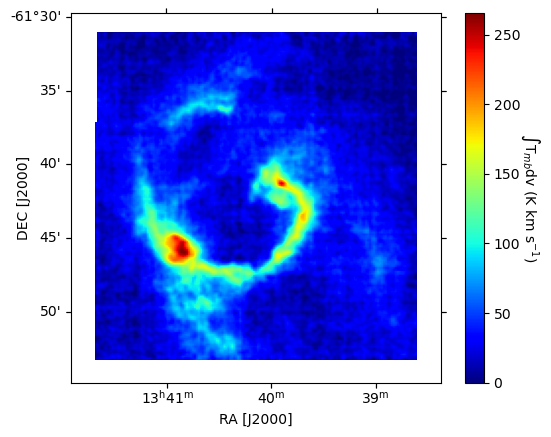

In [5]:
pGMM.inspect_intensity_map(data, dv, w, unit_integrated_intensity)

In [6]:
## reduce the data size along the z-axis to the region associated with emission
data_reduced = vax.reduce_z_axis_size(data, min_velocity, max_velocity, crval, dv, crpix)

The minimal pixel along the z-axis is: 40
The maximal pixel along the z-axis is: 130


In [7]:
## prepare the data before the GMM loop
index_array, data_input = fGMM.prepare_data(data_reduced)

## fit the GMM
(n_comp_list_orig, bic_list_orig, time_list_orig, best_model_orig, norm_lower_bound_list_orig) = fGMM.fit_GMM(data_input, n_comps_min, n_comps_max, print_time = True)
#(n_comp_list_orig, bic_list_orig, time_list_orig, best_model_orig, norm_lower_bound_list_orig) = fGMM.fit_GMM(data_input, n_comps_min, n_comps_max, print_time = True, seed_val = 1109)

Dimensions of resampled data: (90, 35344)
Calculating GMM for 1 components
total time: 0.15865397453308105 s
converged: True
num iterations: 2


Calculating GMM for 2 components


/Users/larsbonne/Documents/code/Astro/GMM/GMM_functions.py:31: RuntimeWarning: All-NaN slice encountered
  max_vals = np.nanmax(data_resample, axis=0)


total time: 2.273940324783325 s
converged: True
num iterations: 24


Calculating GMM for 3 components
total time: 4.095132827758789 s
converged: True
num iterations: 25


Calculating GMM for 4 components
total time: 13.061734914779663 s
converged: True
num iterations: 70


Calculating GMM for 5 components
total time: 8.071144819259644 s
converged: True
num iterations: 31


Calculating GMM for 6 components
total time: 12.746745824813843 s
converged: True
num iterations: 51


Calculating GMM for 7 components
total time: 17.056500911712646 s
converged: True
num iterations: 69


Calculating GMM for 8 components
total time: 20.318515062332153 s
converged: True
num iterations: 63


Calculating GMM for 9 components
total time: 31.83635377883911 s
converged: True
num iterations: 91


Calculating GMM for 10 components
total time: 61.96659207344055 s
converged: True
num iterations: 144




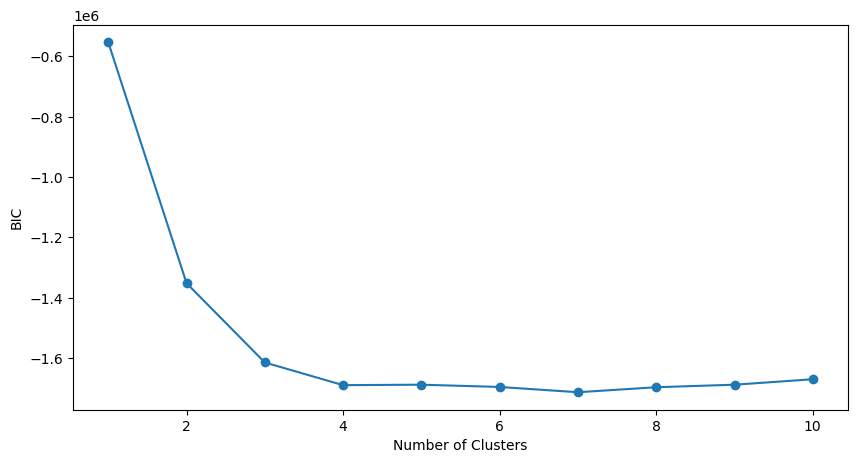

In [8]:
## plot BIC result as a function of the number of components
pGMM.plot_two_lists(n_comp_list_orig, bic_list_orig, "Number of Clusters", "BIC") #, plot_path = 'plots/bic_evol_20.pdf')

The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3
The routine is currently plotting cluster 4
The routine is currently plotting cluster 5
The routine is currently plotting cluster 6


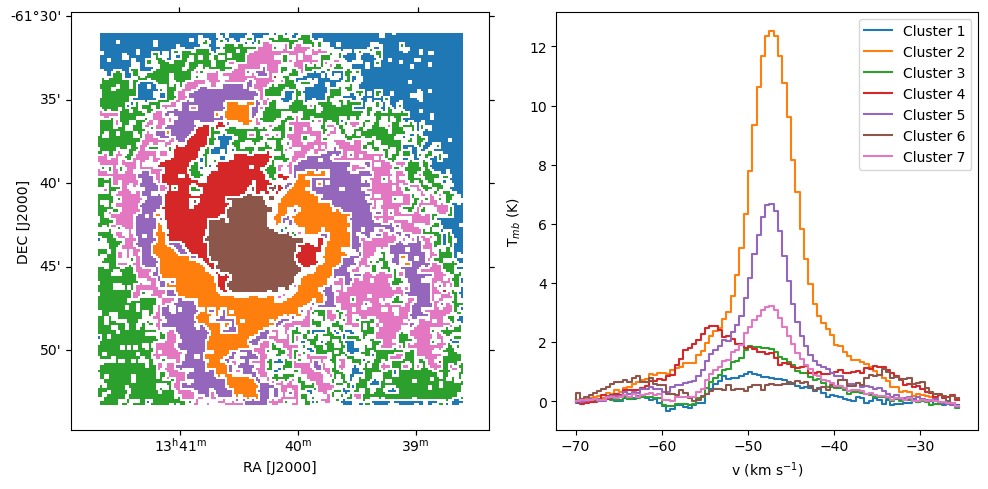

In [9]:
## Obtain the indices for the different clusters
cluster_inds = best_model_orig.predict(data_input)

## Map the spatial distribution of the different clusters
cluster_map = fGMM.map_spatial_cluster_distribution(cluster_inds, index_array, data.shape[2], data.shape[1])

## Create the velocity and resampled velocity array necessary for plotting
vel_arr = vax.create_velocity_array(min_velocity, max_velocity, dv)

## Plot the spectra associated with each cluster and indicate the spatial distribution of the identified spectral clusters
#pGMM.plot_clusters_and_spectra(data_reduced, cluster_map, vel_arr, w, plot_path = path_plots + save_name)
pGMM.plot_clusters_and_spectra(data_reduced, cluster_map, vel_arr, w) #, plot_path = 'plots/cluster_locs+spectra.pdf')

The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3
The routine is currently plotting cluster 4
The routine is currently plotting cluster 5
The routine is currently plotting cluster 6


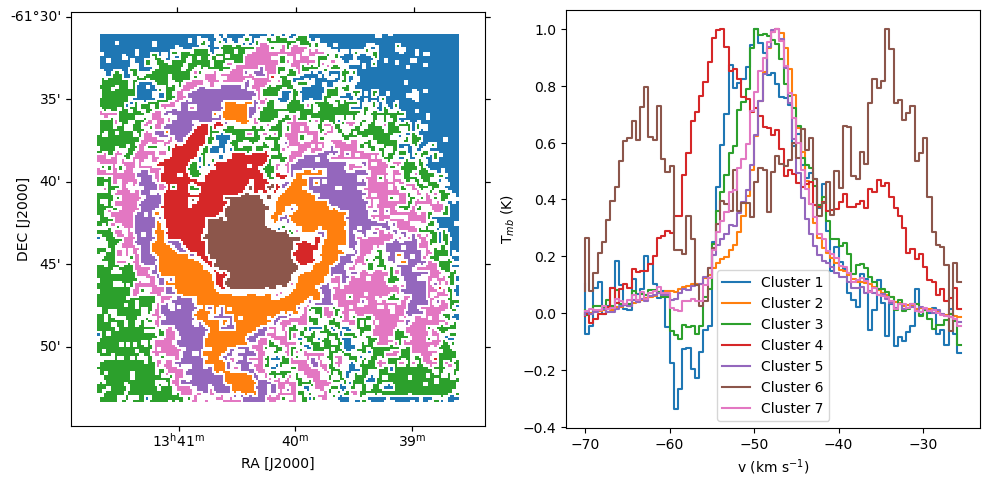

In [10]:
## Plot the normalized spectra associated with each cluster and their spatial distribution
pGMM.plot_clusters_and_spectra(data_reduced, cluster_map, vel_arr, w, normalize = True)

In [11]:
time_lists = []
n_comp_lists = []
bic_lists = []
best_models = []
norm_lower_bounds = []
for dv_resamp in dv_resamps:
    ## resample the spectral axis
    data_resamp = fGMM.resample_data(data_reduced, dv, dv_resamp, resamp_bool = resample_bool)
    
    ## prepare the data for GMM fitting
    index_array, data_input = fGMM.prepare_data(data_resamp)
    
    ## fit the GMM
    print(data_input.shape)
    (n_comp_list, bic_list, time_list, best_model, norm_lower_bound_list) = fGMM.fit_GMM(data_input, n_comps_min1, n_comps_max1, print_time = True)
    
    time_lists.append(time_list)
    n_comp_lists.append(n_comp_list)
    bic_lists.append(bic_list)
    best_models.append(best_model)
    norm_lower_bounds.append(norm_lower_bound_list)
 
#vel_arr_resamp = vax.create_velocity_array(min_velocity, max_velocity, dv_resamp)



The number of spectral bins is reduced by a factor: 2
new shape of the spectral cube: (45, 188, 188)
Dimensions of resampled data: (45, 35344)
(27674, 45)
Calculating GMM for 1 components
total time: 0.04615283012390137 s
converged: True
num iterations: 2


Calculating GMM for 2 components


/Users/larsbonne/Documents/code/Astro/GMM/GMM_functions.py:31: RuntimeWarning: All-NaN slice encountered
  max_vals = np.nanmax(data_resample, axis=0)


total time: 0.7362449169158936 s
converged: True
num iterations: 23


Calculating GMM for 3 components
total time: 1.4131309986114502 s
converged: True
num iterations: 26


Calculating GMM for 4 components
total time: 1.6321041584014893 s
converged: True
num iterations: 21




The number of spectral bins is reduced by a factor: 3
new shape of the spectral cube: (30, 188, 188)
Dimensions of resampled data: (30, 35344)
(27674, 30)
Calculating GMM for 1 components
total time: 0.05344986915588379 s
converged: True
num iterations: 2


Calculating GMM for 2 components


/Users/larsbonne/Documents/code/Astro/GMM/GMM_functions.py:31: RuntimeWarning: All-NaN slice encountered
  max_vals = np.nanmax(data_resample, axis=0)


total time: 0.5583469867706299 s
converged: True
num iterations: 19


Calculating GMM for 3 components
total time: 1.4556541442871094 s
converged: True
num iterations: 29


Calculating GMM for 4 components
total time: 1.1721439361572266 s
converged: True
num iterations: 18




The number of spectral bins is reduced by a factor: 4
new shape of the spectral cube: (23, 188, 188)
Dimensions of resampled data: (23, 35344)
(27674, 23)
Calculating GMM for 1 components
total time: 0.04214286804199219 s
converged: True
num iterations: 2


Calculating GMM for 2 components


/Users/larsbonne/Documents/code/Astro/GMM/GMM_functions.py:31: RuntimeWarning: All-NaN slice encountered
  max_vals = np.nanmax(data_resample, axis=0)


total time: 0.36023712158203125 s
converged: True
num iterations: 12


Calculating GMM for 3 components
total time: 0.924523115158081 s
converged: True
num iterations: 27


Calculating GMM for 4 components
total time: 0.6774682998657227 s
converged: True
num iterations: 17




In [12]:
## definition of linear and quadratic functions
def lin_func(x, a, b):
    return a*x + b

def quad_func(x, a, b):
    return a * x**2 + b

In [13]:
x_plot_orig = np.linspace(n_comps_min, n_comps_max, num = 200)
x_ver_orig = [i for i in range(n_comps_min, n_comps_max)]

## fit the time evolution of the unresampled data with a linear function
popt_o, pcov_o = curve_fit(lin_func, n_comp_list_orig, time_list_orig)
lin_fit_orig = lin_func(x_plot_orig, popt_o[0], popt_o[1])
lin_ver_orig = [lin_func(val, popt_o[0], popt_o[1]) for val in x_ver_orig]

## fit the time evolution of the unresampled data with a quadratic function
popt_o, pcov_o = curve_fit(quad_func, n_comp_list_orig, time_list_orig)
quad_fit_orig = quad_func(x_plot_orig, popt_o[0], popt_o[1])
quad_ver_orig = [quad_func(val, popt_o[0], popt_o[1]) for val in x_ver_orig]

In [14]:
## fit the linear and quadratic function for the time evolution
x_plot = np.linspace(n_comps_min1, n_comps_max1, num = 200)
x_ver = [i for i in range(n_comps_min1, n_comps_max1)]
lin_fits = []
lin_vers = []
quad_fits = []
quad_vers = []
for time_list, n_comp in zip(time_lists, n_comp_lists):
    ## fit the linear function and store the predicted function for plotting
    popt, pcov = curve_fit(lin_func, n_comp, time_list)
    lin_fits.append(lin_func(x_plot, popt[0], popt[1]))
    lin_vers.append([lin_func(val, popt[0], popt[1]) for val in x_ver])
    
    ## fit the quadratic functions and store the predicted function for plotting
    popt, pcov = curve_fit(quad_func, n_comp, time_list)
    quad_fits.append(quad_func(x_plot, popt[0], popt[1]))
    quad_vers.append([quad_func(val, popt[0], popt[1]) for val in x_ver])

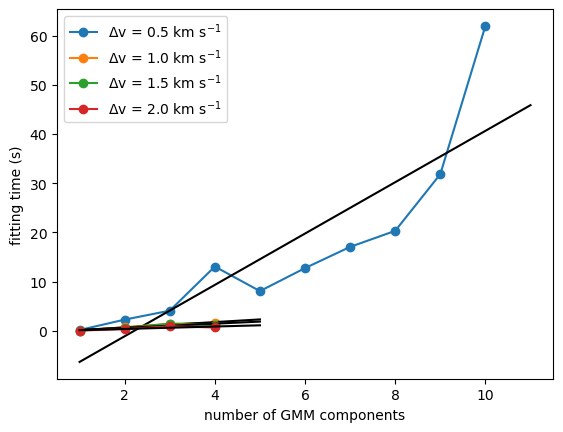

In [15]:
## study the time evolution for the different resampling values with a linear fit
plt.plot(n_comp_list_orig, time_list_orig, 'o-', label = '{dv} = {vel} km {sm}'.format(dv = '$\Delta$v', vel = round(dv, 1), sm = 's$^{-1}$'))
plt.plot(x_plot_orig, lin_fit_orig, 'k-')
for time_list, n_comp, dv_resamp, lin_fit in zip(time_lists, n_comp_lists, dv_resamps, lin_fits):
    ## plot the needed time
    plt.plot(n_comp, time_list, 'o-', label = '{dv} = {vel} km {sm}'.format(dv = '$\Delta$v', vel = round(dv_resamp, 1), sm = 's$^{-1}$'))
    
    ## plot the fitted linear function 
    plt.plot(x_plot, lin_fit, 'k-')
    
plt.xlabel('number of GMM components')
plt.ylabel('fitting time (s)')
plt.legend()
#plt.savefig('plots/time_linfit_resample.pdf', dpi = 300)
plt.show()

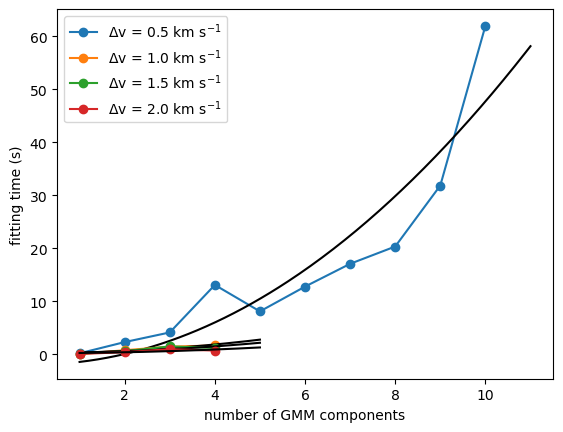

In [16]:
## study the time evolution for the different resampling values with a quadratic fit
plt.plot(n_comp_list_orig, time_list_orig, 'o-', label = '{dv} = {vel} km {sm}'.format(dv = '$\Delta$v', vel = round(dv, 1), sm = 's$^{-1}$'))
plt.plot(x_plot_orig, quad_fit_orig, 'k-')
for time_list, n_comp, dv_resamp, quad_fit in zip(time_lists, n_comp_lists, dv_resamps, quad_fits):
    ## plot the needed time
    plt.plot(n_comp, time_list, 'o-', label = '{dv} = {vel} km {sm}'.format(dv = '$\Delta$v', vel = round(dv_resamp, 1), sm = 's$^{-1}$'))
    
    ## plot the fitted linear function 
    plt.plot(x_plot, quad_fit, 'k-')
    
plt.xlabel('number of GMM components')
plt.ylabel('fitting time (s)')
plt.legend()
#plt.savefig('plots/time_quadfit_resample.pdf', dpi = 300)
plt.show()

In [17]:
## perform KS-test
## for the original bin sampling
print(kstest(time_list_orig, lin_fit_orig))
print(kstest(time_list_orig, quad_fit_orig))

KstestResult(statistic=0.29, pvalue=0.3395748642511645, statistic_location=20.318515062332153, statistic_sign=1)
KstestResult(statistic=0.23, pvalue=0.6257052431251754, statistic_location=20.318515062332153, statistic_sign=1)


In [18]:
## perform KS-test
## for the bin resampling

for time_list, lin_fit, quad_fit in zip(time_lists, lin_fits, quad_fits):
    print(kstest(time_list, lin_fit))
    print(kstest(time_list, quad_fit))

KstestResult(statistic=0.315, pvalue=0.7375070960086056, statistic_location=1.6321041584014893, statistic_sign=1)
KstestResult(statistic=0.31, pvalue=0.7532642710116256, statistic_location=1.6321041584014893, statistic_sign=1)
KstestResult(statistic=0.27, pvalue=0.8674824648244163, statistic_location=0.5583469867706299, statistic_sign=1)
KstestResult(statistic=0.25, pvalue=0.9177147620002529, statistic_location=0.05344986915588379, statistic_sign=1)
KstestResult(statistic=0.265, pvalue=0.8799445482549358, statistic_location=0.36023712158203125, statistic_sign=1)
KstestResult(statistic=0.25, pvalue=0.9177147620002529, statistic_location=0.04214286804199219, statistic_sign=1)


In [19]:
## Neither considering the quadratic and linear relation as a null-hypothesis can be rejected

In [20]:
## make predictions for time cost based on the quadratic function
for idx in range(11, 21):
    print("{num}: {t} seconds".format(num = idx, t = quad_func(idx, popt_o[0], popt_o[1])))

11: 58.14191137970631 seconds
12: 69.56758093553884 seconds
13: 81.98678697448725 seconds
14: 95.39952949655154 seconds
15: 109.80580850173169 seconds
16: 125.20562399002772 seconds
17: 141.59897596143963 seconds
18: 158.9858644159674 seconds
19: 177.36628935361105 seconds
20: 196.74025077437057 seconds


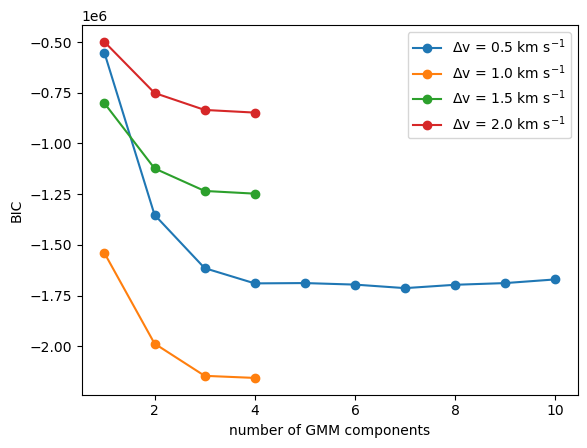

In [21]:
## print the BIC evolution
plt.plot(n_comp_list_orig, bic_list_orig, 'o-', label = '{dv} = {vel} km {sm}'.format(dv = '$\Delta$v', vel = round(dv, 1), sm = 's$^{-1}$'))
for bic_list, n_comp, dv_resamp in zip(bic_lists, n_comp_lists, dv_resamps):
    plt.plot(n_comp, bic_list, 'o-', label = '{dv} = {vel} km {sm}'.format(dv = '$\Delta$v', vel = round(dv_resamp, 1), sm = 's$^{-1}$'))

plt.xlabel('number of GMM components')
plt.ylabel('BIC')
plt.legend()
#plt.savefig('plots/bic_evol_resample.pdf', dpi = 300)
plt.show()

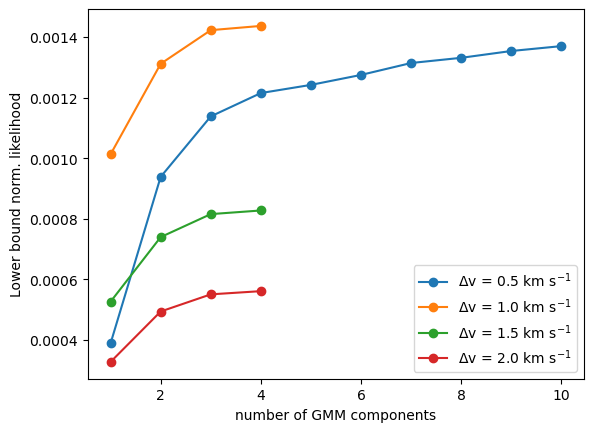

In [22]:
## print the lower bounds evolution
plt.plot(n_comp_list_orig, norm_lower_bound_list_orig, 'o-', label = '{dv} = {vel} km {sm}'.format(dv = '$\Delta$v', vel = round(dv, 1), sm = 's$^{-1}$'))
for nlb_list, n_comp, dv_resamp in zip(norm_lower_bounds, n_comp_lists, dv_resamps):
    plt.plot(n_comp, nlb_list, 'o-', label = '{dv} = {vel} km {sm}'.format(dv = '$\Delta$v', vel = round(dv_resamp, 1), sm = 's$^{-1}$'))

plt.xlabel('number of GMM components')
plt.ylabel('Lower bound norm. likelihood')
plt.legend()
#plt.savefig('plots/norm_lb_evol_resample.pdf', dpi = 300)
plt.show()

In [23]:
## print the best models
for best_model in best_models:
    print(best_model)

GaussianMixture(max_iter=1000, n_components=4, random_state=312)
GaussianMixture(max_iter=1000, n_components=4, random_state=312)
GaussianMixture(max_iter=1000, n_components=4, random_state=312)


## attempt HDBSCAN

In [24]:
## prepare the data before the DBSCAN analysis
index_array, data_input = fGMM.prepare_data(data_reduced)

Dimensions of resampled data: (90, 35344)


/Users/larsbonne/Documents/code/Astro/GMM/GMM_functions.py:31: RuntimeWarning: All-NaN slice encountered
  max_vals = np.nanmax(data_resample, axis=0)


In [25]:
## cluster with HDBSCAN on the data
db1 = DBSCAN(eps = 0.5, min_samples = 25)
db_model1 = db1.fit(data_input)
print(db_model1.labels_.shape)
print(np.nanmin(db_model1.labels_))
print(np.nanmax(db_model1.labels_))

(27674,)
-1
3


The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3


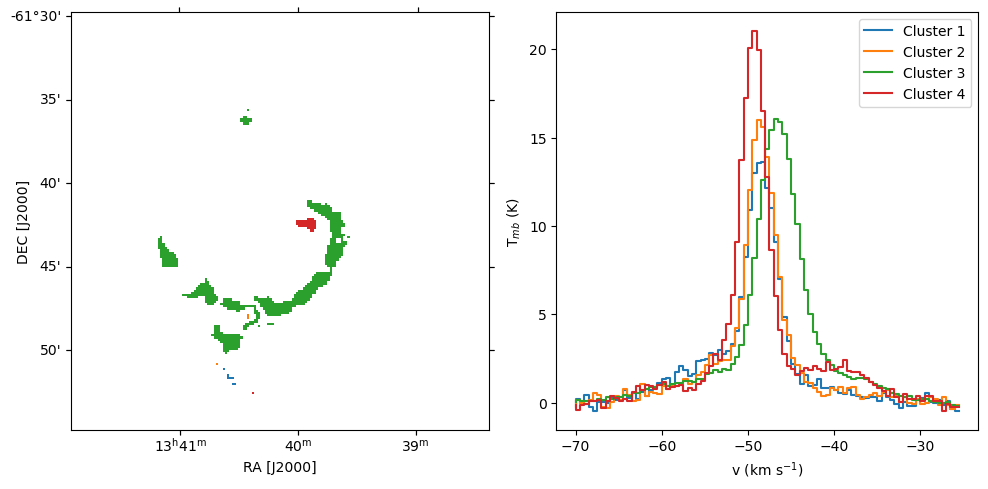

In [26]:
## Obtain the indices for the different clusters
cluster_inds = db_model1.labels_#fit_predict(data_input)

## Map the spatial distribution of the different clusters
cluster_map = fGMM.map_spatial_cluster_distribution(cluster_inds, index_array, data.shape[2], data.shape[1])

## Create the velocity and resampled velocity array necessary for plotting
vel_arr = vax.create_velocity_array(min_velocity, max_velocity, dv)

## Plot the spectra associated with each cluster and indicate the spatial distribution of the identified spectral clusters
pGMM.plot_clusters_and_spectra(data_reduced, cluster_map, vel_arr, w) #, plot_path = 'plots/cluster_locs+spectra.pdf')

In [27]:
## cluster with HDBSCAN on the data
db2 = DBSCAN(eps = 0.75, min_samples = 25)
db_model2 = db2.fit(data_input)
print(db_model2.labels_.shape)
print(np.nanmin(db_model2.labels_))
print(np.nanmax(db_model2.labels_))

(27674,)
-1
0


The routine is currently plotting cluster 0


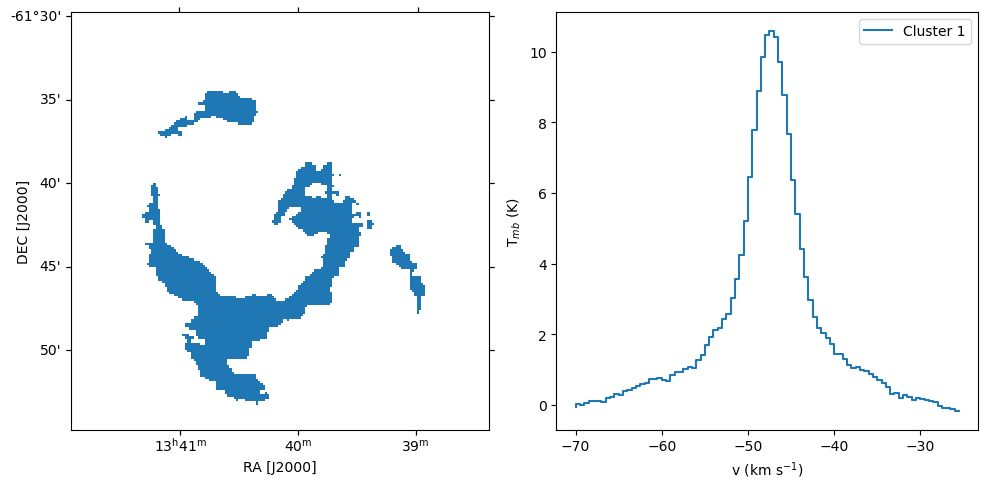

In [28]:
## Obtain the indices for the different clusters
cluster_inds = db_model2.labels_#predict(data_input)

## Map the spatial distribution of the different clusters
cluster_map = fGMM.map_spatial_cluster_distribution(cluster_inds, index_array, data.shape[2], data.shape[1])

## Create the velocity and resampled velocity array necessary for plotting
vel_arr = vax.create_velocity_array(min_velocity, max_velocity, dv)

## Plot the spectra associated with each cluster and indicate the spatial distribution of the identified spectral clusters
pGMM.plot_clusters_and_spectra(data_reduced, cluster_map, vel_arr, w)

In [29]:
## cluster with HDBSCAN on the data
db3 = DBSCAN(eps = 0.25, min_samples = 5)
db_model3 = db3.fit(data_input)
print(db_model3.labels_.shape)
print(np.nanmin(db_model3.labels_))
print(np.nanmax(db_model3.labels_))

(27674,)
-1
14


The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3
The routine is currently plotting cluster 4
The routine is currently plotting cluster 5
The routine is currently plotting cluster 6
The routine is currently plotting cluster 7
The routine is currently plotting cluster 8
The routine is currently plotting cluster 9
The routine is currently plotting cluster 10
The routine is currently plotting cluster 11
The routine is currently plotting cluster 12
The routine is currently plotting cluster 13
The routine is currently plotting cluster 14


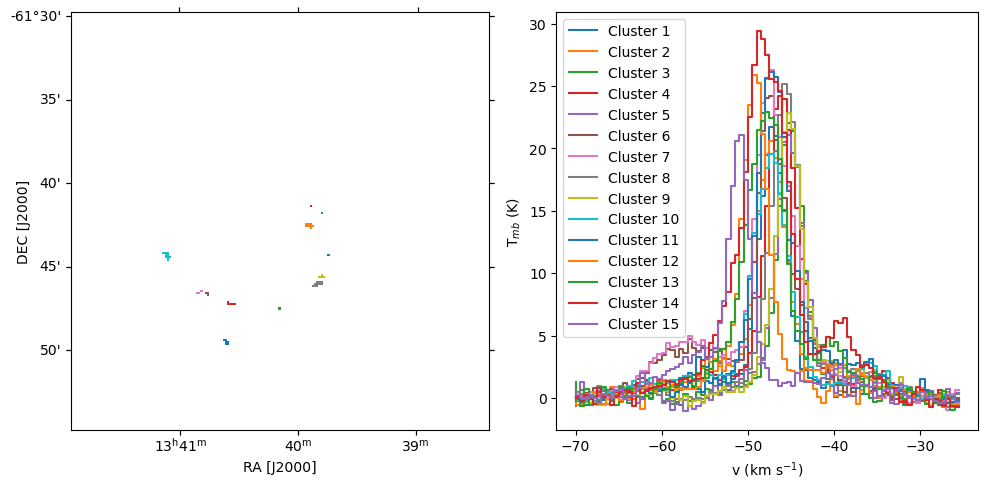

In [30]:
## Obtain the indices for the different clusters
cluster_inds = db_model3.labels_#predict(data_input)

## Map the spatial distribution of the different clusters
cluster_map = fGMM.map_spatial_cluster_distribution(cluster_inds, index_array, data.shape[2], data.shape[1])

## Create the velocity and resampled velocity array necessary for plotting
vel_arr = vax.create_velocity_array(min_velocity, max_velocity, dv)

## Plot the spectra associated with each cluster and indicate the spatial distribution of the identified spectral clusters
pGMM.plot_clusters_and_spectra(data_reduced, cluster_map, vel_arr, w)